# Filtering `hf_hydrodata.point` sites by a USGS HUC boundary shapefile

This notebook provides an example of how to download a HUC boundary shapefile from the USGS and filter observations to only sites that are located within that HUC.

In [1]:
# Import packages
from hf_hydrodata.point import get_data, get_metadata
from hf_hydrodata.gridded import register_api_pin
import requests
from zipfile import ZipFile
from io import BytesIO
import shapefile
from shapely.geometry import shape

In [ ]:
# You need to register on https://hydrogen.princeton.edu/pin 
# and run the following with your registered information
# before you can use the hydrodata utilities
register_api_pin("your_email", "your_pin")

## Step 1: Download HUC-02 regional shapefile from USGS

The USGS has HUC shapefiles available for download from [The National Map](https://apps.nationalmap.gov/downloader/) (to see what is available, select the Watershed Boundary Dataset). The National Map provides a visual interface for viewing, selecting, and downloading various datasets. These files are available either for the entire nation or by HUC-02 regions. For the purposes of this notebook, we will download a HUC-02 regional shapefile programmatically to allow for full reproducibility. [This link](https://www.sciencebase.gov/catalog/item/5a1632b3e4b09fc93dd171de) provides more detail about the specific files we will be downloading.

In [2]:
# Send request for data
url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/Shape/WBD_02_HU2_Shape.zip'
url_response = requests.get(url)    # note this might take a minute or so to run

In [3]:
# See the names of the files available in the .zip
myzipfile = ZipFile(BytesIO(url_response.content))
print(myzipfile.namelist())

['Shape/ExternalCrosswalk.dbf', 'Shape/FeatureToMetadata.dbf', 'Shape/HUMod.dbf', 'Shape/MetaProcessDetail.dbf', 'Shape/MetaSourceDetail.dbf', 'Shape/NonContributingDrainageArea.dbf', 'Shape/NonContributingDrainageArea.prj', 'Shape/NonContributingDrainageArea.shp', 'Shape/NonContributingDrainageArea.shx', 'Shape/NonContributingDrainageLine.dbf', 'Shape/NonContributingDrainageLine.prj', 'Shape/NonContributingDrainageLine.shp', 'Shape/NonContributingDrainageLine.shx', 'Shape/NWISDrainageArea.dbf', 'Shape/NWISDrainageArea.prj', 'Shape/NWISDrainageArea.shp', 'Shape/NWISDrainageArea.shx', 'Shape/NWISDrainageLine.dbf', 'Shape/NWISDrainageLine.prj', 'Shape/NWISDrainageLine.shp', 'Shape/NWISDrainageLine.shx', 'Shape/ProcessingParameters.dbf', 'Shape/UpdateStatus.dbf', 'Shape/WBDHU10.dbf', 'Shape/WBDHU10.prj', 'Shape/WBDHU10.shp', 'Shape/WBDHU10.shx', 'Shape/WBDHU12.dbf', 'Shape/WBDHU12.prj', 'Shape/WBDHU12.shp', 'Shape/WBDHU12.shx', 'Shape/WBDHU14.dbf', 'Shape/WBDHU14.prj', 'Shape/WBDHU14.shp'

In [4]:
# In this example, we will extract only the files with the HUC8 level watersheds
# This code saves these files to the local directory where this notebook is being run
myzipfile.extractall(members=['Shape/WBDHU8.shp', 'Shape/WBDHU8.shx', 'Shape/WBDHU8.dbf', 'Shape/WBDHU8.prj'])

In [5]:
# Read in shapefile
huc02_shp = shapefile.Reader('Shape/WBDHU8.shp')

In [6]:
# Read in projection file
with open('Shape/WBDHU8.prj') as f:
    usgs_huc_crs = f.readlines()[0]
print(f"CRS: {usgs_huc_crs}")

CRS: GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]


## Step 2: Subset shapefile to desired HUC-08 watershed

In [7]:
# Let's explore what HUC8 watersheds are within this HUC2 region
for i in range(len(huc02_shp.shapeRecords())):
    print(huc02_shp.shapeRecord(i=i, fields=['states', 'huc8', 'name']).record)

Record #0: ['DC,MD,VA,WV', '02070008', 'Middle Potomac-Catoctin']
Record #1: ['DC,MD,VA', '02070010', 'Middle Potomac-Anacostia-Occoquan']
Record #2: ['MD', '02060006', 'Patuxent']
Record #3: ['VA', '02040304', 'Eastern Lower Delmarva']
Record #4: ['NJ,NY', '02040301', 'Mullica-Toms']
Record #5: ['DE,NJ', '02040204', 'Delaware Bay']
Record #6: ['NY', '02020002', 'Sacandaga']
Record #7: ['MD,PA', '02050306', 'Lower Susquehanna']
Record #8: ['MD,PA', '02070009', 'Monocacy']
Record #9: ['VA', '02080103', 'Rapidan-Upper Rappahannock']
Record #10: ['VA', '02080105', 'Mattaponi']
Record #11: ['DE,MD,VA', '02080110', 'Tangier']
Record #12: ['MD,VA,WV', '02070001', 'South Branch Potomac']
Record #13: ['NJ,NY', '02030104', 'Sandy Hook-Staten Island']
Record #14: ['NJ,NY,RI', '02030202', 'Southern Long Island']
Record #15: ['NJ,NY', '02030103', 'Hackensack-Passaic']
Record #16: ['NJ,NY,PA', '02040104', 'Middle Delaware-Mongaup-Brodhead']
Record #17: ['DE,NJ', '02040206', 'Cohansey-Maurice']
Reco

In [8]:
# We want to use the Raritan watershed, HUC8='02030105'. This is at index 72
print(huc02_shp.shapeRecord(i=72, fields=['states', 'huc8', 'name']).record)

# Extract the shape and record information for this index
raritan_shape = huc02_shp.shapeRecord(i=72).shape
raritan_record = huc02_shp.shapeRecord(i=72).record

Record #72: ['NJ', '02030105', 'Raritan']


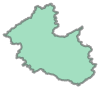

In [9]:
# Display the shape of the selected watershed
raritan_geo = huc02_shp.shapeRecord(i=72).shape.__geo_interface__
shape(raritan_geo)

In [10]:
# Save as shapefile, to be passed in to hf_hydrodata functions below
with shapefile.Writer('Shape/raritan_watershed') as w:
    w.fields = huc02_shp.fields[1:]

    w.record(raritan_record)
    w.shape(raritan_shape)

## Step 3: Request streamflow data for sites within the watershed

In [11]:
# Let's request daily streamflow data for the Water Year 2022 for sites that fall within this watershed
data_source = 'usgs_nwis'
variable = 'streamflow'
temporal_resolution = 'daily'
aggregation = 'average'

In [12]:
data_df = get_data(data_source, variable, temporal_resolution, aggregation,
                   date_start='2021-10-01', date_end='2022-09-30',
                   polygon='Shape/raritan_watershed.shp', polygon_crs=usgs_huc_crs)
data_df.head(5)

,date,01396500,01396582,01396660,01396800,01397000,01398000,01398500,01399100,01399500,...,01402000,01403060,01403150,01403400,01403540,01403900,01405030,01405400,01406050,01402630
0,2021-10-01,2.37437,0.067354,0.238569,0.98201,4.6978,0.260926,1.16596,0.196685,1.46311,...,3.9054,11.9143,0.006792,0.050657,0.086032,0.94805,0.58015,0.75844,0.194704,0.053204
1,2021-10-02,2.26400,0.062260,0.231777,0.90560,4.4997,0.238569,1.17162,0.157348,1.32161,...,NaN,11.2068,0.007075,0.047827,0.085749,0.91409,0.57449,0.71316,0.179422,0.050940
2,2021-10-03,2.20174,0.057449,0.229513,0.89145,4.3582,0.227532,1.17445,0.153669,1.27067,...,3.3960,10.1314,0.006226,0.047261,0.087730,0.89711,0.55751,0.68486,0.168668,0.051223
3,2021-10-04,4.24500,1.044270,0.444310,1.03012,5.2355,0.240833,2.66586,0.461290,1.79705,...,NaN,11.8294,0.035658,0.164989,0.245361,2.39135,0.56883,0.80938,0.223287,0.128765
4,2021-10-05,4.44310,0.506570,0.328280,1.05276,8.2636,0.258662,1.74328,0.399030,1.94421,...,3.7073,22.2438,0.018395,0.105276,0.151122,2.11684,0.62826,1.12351,0.549020,0.102446


In [13]:
metadata_df = get_metadata(data_source, variable, temporal_resolution, aggregation,
                           date_start='2021-10-01', date_end='2022-09-30',
                           polygon='Shape/raritan_watershed.shp', polygon_crs=usgs_huc_crs)
metadata_df.head(5)

,site_id,site_name,site_type,agency,state,latitude,longitude,first_date_data_available,last_date_data_available,record_count,...,doi,huc8,conus1_x,conus1_y,conus2_x,conus2_y,gagesii_drainage_area,gagesii_class,gagesii_site_elevation,usgs_drainage_area
0,01396500,South Branch Raritan River near High Bridge NJ,stream gauge,USGS,NJ,40.677778,-74.879167,1918-10-01,2023-11-11,38393,...,None,02030105,nan,nan,3993,1995,162.52470,Non-ref,93.0,65.3
1,01396582,Spruce Run at Main Street at Glen Gardner NJ,stream gauge,USGS,NJ,40.691389,-74.936944,1978-03-24,2023-11-11,15534,...,None,02030105,nan,nan,3986,1993,32.08680,Non-ref,117.0,12.3
2,01396660,Mulhockaway Creek at Van Syckel NJ,stream gauge,USGS,NJ,40.647500,-74.968889,1977-07-29,2023-11-11,16906,...,None,02030105,nan,nan,3987,1985,30.44061,Non-ref,85.0,11.8
3,01396800,Spruce Run at Clinton NJ,stream gauge,USGS,NJ,40.640000,-74.915556,1960-10-01,2023-11-11,23050,...,None,02030105,nan,nan,3990,1985,107.84340,Non-ref,67.0,41.3
4,01397000,South Branch Raritan River at Stanton NJ,stream gauge,USGS,NJ,40.572222,-74.868056,1903-10-01,2023-11-11,39124,...,None,02030105,nan,nan,3997,1979,388.62720,Non-ref,40.0,147.0
